In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import SequentialFeatureSelector
import lightgbm as lgb

import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
### Load dataset

In [5]:
df_cic_ids2018 = pd.read_csv('/content/drive/MyDrive/datasets/encoded_ids2018.csv')

In [6]:
ids2018_x = df_cic_ids2018.drop('Label', axis=1).copy()
ids2018_y = df_cic_ids2018['Label'].copy()

In [7]:
#1. Split dataset into Training and Test and Scaling 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ids2018_x, ids2018_y, test_size=0.20, random_state=1, stratify=ids2018_y)

In [8]:
# Standardize  training dataset   
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))

X_train.columns = ids2018_x.columns

In [9]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [10]:
concatenated_train = pd.concat([X_train, y_train], axis=1)

In [9]:
#2.Feature selection using only Training dataset: 

#2.Feature selection using only Training dataset 


*   correlation metrics : Point Bi-Serial
*   Weight of Evidence (WOE) and Information Value (IV)
*   Beta coefficients for Logistic regression
*   Recursive Feature Elimination (RFE)
*   BorutaPy
*   Boruta SHAP

In [13]:
##correlation metrics : Point Bi-Serial
# Categorical - Continuous

from scipy import stats

#1.Select the top n features based on absolute correlation with train_target variable

# Correlation
point_bi_serial_list = ['Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Avg Packet Size',
       'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes',
       'Init Fwd Win Bytes', 'Init Bwd Win Bytes', 'Fwd Act Data Packets',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


point_bi_serial_threshold = .5

################################ Functions #############################################################


def corr_feature_selection(data,target, point_bi_serial_list, point_bi_serial_threshold):
    
    #Inputs
    # data - Input feature data
    # target - Target Variable
    # pearson_list - list of continuous features (if target is continuous)
    # point_bi_serial_list - list of continuous features (if target is categorical)/
    #                        list of categorical features (if target is continuous)   
    # point_bi_serial_threshold - select features if biserial corrrelation is above this
    
    
    corr_data = pd.DataFrame()# Calculate point bi-serial
    for i in point_bi_serial_list:
        # Manual Change in Parameters - Point Bi-Serial
        # Link to function parameters - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html
        pbc = stats.pointbiserialr(target, data[i])   
        corr_temp_data = [[i,pbc.correlation,"point_bi_serial"]]
        corr_temp_df = pd.DataFrame(corr_temp_data, 
                                    columns = ['Feature', 
                                               'Correlation',
                                               'Correlation_Type'])
        #corr_data = corr_data.append(corr_temp_df)
        corr_data = pd.concat([corr_data, corr_temp_df], ignore_index=True)
  
    # Filter NA and sort based on absolute correlation
    corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()] 
    corr_data = corr_data[corr_data['Correlation'].notna()]
    corr_data = corr_data.loc[corr_data['Correlation'] != 1]
    
    # Add thresholds
    
    # initialize list of lists
    data = [['point_bi_serial', point_bi_serial_threshold],]    
    threshold_df = pd.DataFrame(data, columns=['Correlation_Type','Threshold'])
    corr_data = pd.merge(corr_data,threshold_df,
                         on=['Correlation_Type'],how = 'left')# Select Features with greater than user dfined absolute correlation
    corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > corr_data['Threshold']]
    corr_top_features = corr_data2['Feature'].tolist()
    print(corr_top_features)
    corr_top_features_df = pd.DataFrame(corr_top_features,columns = ['Feature'])
    corr_top_features_df['Method'] = 'Correlation'
    return corr_data,corr_top_features_df
################################ Calculate Correlation #############################################################

corr_data,corr_top_features_df = corr_feature_selection(X_train, y_train, point_bi_serial_list, point_bi_serial_threshold)
    
    
corr_data.head(30)

[]


,Feature,Correlation,Correlation_Type,Threshold
0,URG Flag Count,-0.002350,point_bi_serial,0.5
1,Idle Min,0.003358,point_bi_serial,0.5
2,Fwd IAT Mean,0.005990,point_bi_serial,0.5
3,Fwd Packets Length Total,-0.007138,point_bi_serial,0.5
4,Subflow Fwd Bytes,-0.007138,point_bi_serial,0.5
5,Idle Mean,0.010722,point_bi_serial,0.5
6,Subflow Bwd Bytes,-0.011247,point_bi_serial,0.5
7,Bwd Packets Length Total,-0.011247,point_bi_serial,0.5
8,FIN Flag Count,0.013189,point_bi_serial,0.5
9,Fwd Header Length,-0.014959,point_bi_serial,0.5


In [14]:
##Weight of Evidence (WOE) and Information Value (IV)

#2. Select top features based on information value# Information value

show_woe = True
iv_bins = 10
iv_threshold = .1

################################ Functions #############################################################

def iv_woe(data, target, iv_bins,iv_threshold, show_woe):
    
    #Inputs
    # data - Input Data including target variable
    # target - Target Variable name
    # iv_bins - Number of iv_bins
    # show_woe - show all the iv_bins and features
    # iv_threshold - select features with IV greater than this
    
    #Empty Dataframe

    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], iv_bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        # Calculate the number of events in each group (bin)

        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        
        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        # Calculate WOE by taking natural log of division of % 
        # of non-events and % of events
        
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + 
              str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars],
                            "IV" : [d['IV'].sum()]},
                           columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
        
        #Show WOE Table
        if show_woe == True:
            print(d)
    
    # Aggregate IV at feature level
    woeDF_v2 = pd.DataFrame(woeDF.groupby('Variable')['IV'].agg('sum'), columns= ['IV']).reset_index()
    woeDF_v3 = woeDF_v2.sort_values(['IV'], ascending = False)
    IV_df = woeDF_v2[woeDF_v2['IV']> iv_threshold]
    woe_top_features = IV_df['Variable'].tolist()
    print(woe_top_features)
    woe_top_features_df = pd.DataFrame(woe_top_features,columns = ['Feature'])
    woe_top_features_df['Method'] = 'Information_value'
    
    return newDF, woeDF,IV_df, woe_top_features_df

################################ Calculate IV #############################################################

train_features_v3_temp = pd.concat([y_train, X_train], axis =1)
newDF, woeDF,IV_df, woe_top_features_df = iv_woe(concatenated_train, 'Label', iv_bins,iv_threshold, show_woe)


woeDF.head(n=30)  

Information value of Destination Port is 10.449721
           Variable            Cutoff       N  Events  % of Events  \
0  Destination Port   (-0.81, -0.807]  204261      48     0.000305   
1  Destination Port  (-0.807, -0.806]  271448  157206     0.999695   
2  Destination Port  (-0.806, -0.791]  120903       0     0.000003   
3  Destination Port  (-0.791, -0.667]  108909       0     0.000003   
4  Destination Port   (-0.667, 0.938]  117065       0     0.000003   
5  Destination Port    (0.938, 1.287]  117486       0     0.000003   
6  Destination Port    (1.287, 1.431]  117500       0     0.000003   
7  Destination Port    (1.431, 1.952]  117505       0     0.000003   

   Non-Events  % of Non-Events        WoE        IV  
0      204213         0.200637  -6.488159  1.299785  
1      114242         0.112242   2.186797  1.940680  
2      120903         0.118786 -10.528332  1.250584  
3      108909         0.107002 -10.423856  1.115339  
4      117065         0.115015 -10.496073  1.207

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Destination Port,"(-0.81, -0.807]",204261,48,0.000305,204213,0.200637,-6.488159,1.299785
1,Destination Port,"(-0.807, -0.806]",271448,157206,0.999695,114242,0.112242,2.186797,1.940680
2,Destination Port,"(-0.806, -0.791]",120903,0,0.000003,120903,0.118786,-10.528332,1.250584
3,Destination Port,"(-0.791, -0.667]",108909,0,0.000003,108909,0.107002,-10.423856,1.115339
4,Destination Port,"(-0.667, 0.938]",117065,0,0.000003,117065,0.115015,-10.496073,1.207173
5,Destination Port,"(0.938, 1.287]",117486,0,0.000003,117486,0.115429,-10.499663,1.211929
6,Destination Port,"(1.287, 1.431]",117500,0,0.000003,117500,0.115442,-10.499782,1.212087
7,Destination Port,"(1.431, 1.952]",117505,0,0.000003,117505,0.115447,-10.499824,1.212144
0,Protocol,-1.851319,14647,0,0.000003,14647,0.014391,-8.417579,0.121107
1,Protocol,-0.42213,963127,157254,1.000000,805873,0.791761,0.233495,0.048623


In [15]:
# Print variable names by predictive power
# Assuming woeDF is the DataFrame containing the IV values
# Sort the DataFrame by IV in descending order
woeDF_sorted = woeDF.sort_values('IV', ascending=False)

# Categorize the predictive power based on IV value
woeDF_sorted['Predictive Power'] = pd.cut(woeDF_sorted['IV'],
                                         bins=[-float('inf'), 0.1, 0.3, float('inf')],
                                         labels=['Weak', 'Medium', 'Strong'])

# Filter the DataFrame for IV values greater than 0.1
woeDF_filtered = woeDF_sorted[woeDF_sorted['IV'] > 0.1]

# Extract unique 'Variable' names
unique_variable_table = woeDF_filtered[['Variable', 'Predictive Power']].drop_duplicates().sort_values('Predictive Power', ascending=False)

# Print the unique variable table
print('=================================================================')
print('Features Information Value')
print()
print("IV > 0.1: Predictive power is Weak")
print("0.1 < IV < 0.3: Predictive power is Medium")
print("IV > 0.3: Predictive power is Strong")
print()
print('=================================================================')
print(unique_variable_table)
print()
print('=================================================================')

# Count variable names by predictive power
count_weak = unique_variable_table['Predictive Power'].eq('Weak').sum()
count_medium = unique_variable_table['Predictive Power'].eq('Medium').sum()
count_strong = unique_variable_table['Predictive Power'].eq('Strong').sum()

# Print variable names by predictive power
variable_names_weak = unique_variable_table.loc[unique_variable_table['Predictive Power'] == 'Weak', 'Variable'].tolist()
variable_names_medium = unique_variable_table.loc[unique_variable_table['Predictive Power'] == 'Medium', 'Variable'].tolist()
variable_names_strong = unique_variable_table.loc[unique_variable_table['Predictive Power'] == 'Strong', 'Variable'].tolist()

print("Variable names with weak predictive power:")
print('=================================================================')
print(variable_names_weak)
print('=================================================================')
print("Number of variable names with weak predictive power:", count_weak)
print('=================================================================')
print()
print()
print('=================================================================')
print("Variable names with medium predictive power:")
print('=================================================================')
print(variable_names_medium)
print('=================================================================')
print("Number of variable names with medium predictive power:", count_medium)
print('=================================================================')
print()
print()
print('=================================================================')
print("Variable names with strong predictive power:")
print('=================================================================')
print(variable_names_strong)
print('=================================================================')
print("Number of variable names with strong predictive power:", count_strong)
print('=================================================================')

Features Information Value

IV > 0.1: Predictive power is Weak
0.1 < IV < 0.3: Predictive power is Medium
IV > 0.3: Predictive power is Strong

                  Variable Predictive Power
2       Init Fwd Win Bytes           Strong
6        Bwd Header Length           Strong
1     Avg Fwd Segment Size           Strong
1   Fwd Packet Length Mean           Strong
3             Flow IAT Max           Strong
..                     ...              ...
1             Flow IAT Max           Medium
4     Avg Fwd Segment Size           Medium
4   Fwd Packet Length Mean           Medium
8           Flow Packets/s           Medium
0                 Protocol           Medium

[92 rows x 2 columns]

Variable names with weak predictive power:
[]
Number of variable names with weak predictive power: 0


Variable names with medium predictive power:
['Fwd IAT Std', 'Bwd Packets Length Total', 'Subflow Bwd Bytes', 'Avg Packet Size', 'Fwd Header Length', 'Flow IAT Mean', 'Packet Length Mean', 'Fwd IAT Tot

In [16]:
##Beta coefficients for Logistic regression:
#Select  the top n features based on absolute value of beta coefficient of features
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Beta Coefficients
beta_threshold = 10

################################ Functions #######################################

def beta_coeff(data, train_target,beta_threshold):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # beta_threshold - select n features with highest absolute beta coeficient value
    
    # Standardise dataset   
    
    #scaler = StandardScaler()
    #data = pd.DataFrame(scaler.fit_transform(data))
    #data.columns = data.columns
    
# Fit Logistic on Standardised dataset
    # Manual Change in Parameters - Logistic Regression
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html       
    
    log = LogisticRegression(fit_intercept = False, penalty = 'none')
    
    log.fit(data, train_target)
    
    coef_table = pd.DataFrame(list(data.columns)).copy()
    
    coef_table.insert(len(coef_table.columns),"Coefs", log.coef_.transpose())
    
    coef_table = coef_table.iloc[coef_table.Coefs.abs().argsort()]
    
    sr_data = coef_table.tail(beta_threshold)
    
    beta_top_features = sr_data.iloc[:,0].tolist()
    
    print(beta_top_features)
    
    beta_top_features_df = pd.DataFrame(beta_top_features,columns = ['Feature'])
    beta_top_features_df['Method'] = 'Beta_coefficients' 
    log_v2 = sm.Logit(train_target,\
                     sm.add_constant(data[beta_top_features])).fit()
    print('Logistic Regression with selected features')
    print(log_v2.summary())
    
    return log, log_v2, beta_top_features_df

################################ Calculate Beta Coeff ################################################

standardised_logistic, logistic_beta_features, beta_top_features_df = beta_coeff(X_train, y_train, beta_threshold)
beta_top_features_df.head(n=20)

['Packet Length Mean', 'Protocol', 'Packet Length Std', 'Fwd Packet Length Std', 'Bwd Packet Length Std', 'Bwd Packet Length Max', 'PSH Flag Count', 'ACK Flag Count', 'Packet Length Max', 'Fwd Seg Size Min']
Optimization terminated successfully.
         Current function value: 0.047085
         Iterations 19
Logistic Regression with selected features
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:              1175077
Model:                          Logit   Df Residuals:                  1175066
Method:                           MLE   Df Model:                           10
Date:                Wed, 31 May 2023   Pseudo R-squ.:                  0.8804
Time:                        23:52:26   Log-Likelihood:                -55328.
converged:                       True   LL-Null:                   -4.6250e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
              

,Feature,Method
0,Packet Length Mean,Beta_coefficients
1,Protocol,Beta_coefficients
2,Packet Length Std,Beta_coefficients
3,Fwd Packet Length Std,Beta_coefficients
4,Bwd Packet Length Std,Beta_coefficients
5,Bwd Packet Length Max,Beta_coefficients
6,PSH Flag Count,Beta_coefficients
7,ACK Flag Count,Beta_coefficients
8,Packet Length Max,Beta_coefficients
9,Fwd Seg Size Min,Beta_coefficients


In [15]:
##L1 regularization to Logistic Regression (Lasso with Logistic regression)
#Select the features identified by Lasso regression

lasso_param = 0.5

################################ Functions ##################################################

def lasso(data, train_target, lasso_param):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # lasso_param - Lasso l1 penalty term
    
    #Fit Logistic
    # Manual Change in Parameters - Logistic Regression
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html       
    
    log = LogisticRegression(penalty ='l1', solver = 'saga',\
                             C = lasso_param)
    log.fit(data, train_target)
    
    #Select Features
    lasso_df = pd.DataFrame(columns = ['Feature', 'Lasso_Coef'])
    lasso_df['Feature'] = data.columns
    lasso_df['Lasso_Coef'] = log.coef_.squeeze().tolist()
    lasso_df_v2 = lasso_df[lasso_df['Lasso_Coef'] !=0]
    lasso_top_features = lasso_df_v2['Feature'].tolist()
    
    lasso_top_features_df = pd.DataFrame(lasso_top_features,\
                                         columns = ['Feature'])
    lasso_top_features_df['Method'] = 'Lasso'
    
    # Logistic Regression with selected features
    log_v2 = sm.Logit(train_target,\
                   sm.add_constant(data[lasso_top_features])).fit()    
    print('Logistic Regression with selected features')
    print(log_v2.summary())
    
    return log_v2, lasso_top_features_df


################################ Calculate Lasso ################################################

logistic_lasso_features, lasso_top_features_df = lasso(X_train, y_train, lasso_param)

lasso_top_features_df.head(n=20)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: ignored

Optimal number of features: 48
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Avg Packet Size', 'Init Fwd Win Bytes', 'Init Bwd Win Bytes', 'Fwd Act Data Packets', 'Fwd Seg Size Min', 'Active Mean', 'Active Max', 'Idle Mean', 'Idle Max']


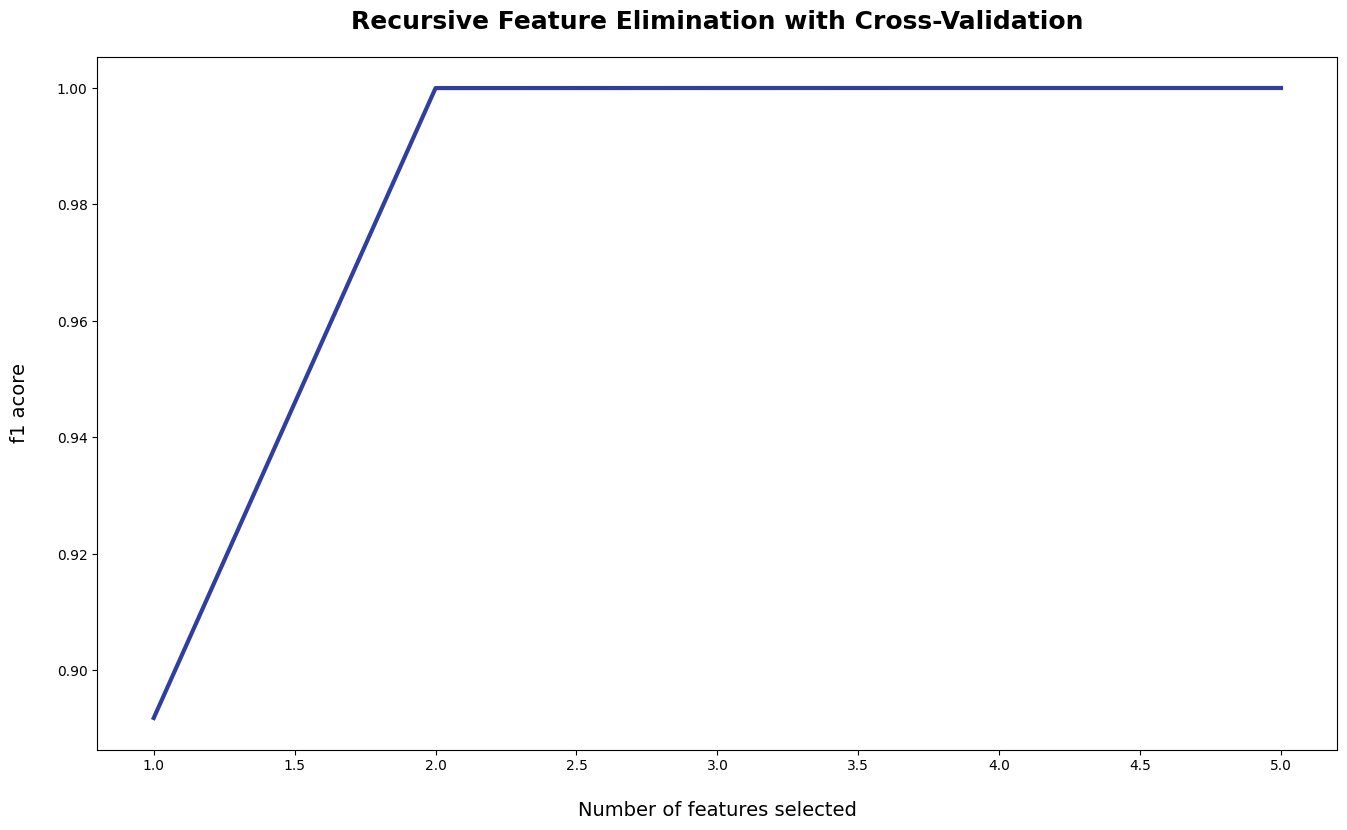

,Feature,Method
0,Destination Port,RFECV
1,Flow Duration,RFECV
2,Total Fwd Packets,RFECV
3,Total Backward Packets,RFECV
4,Fwd Packets Length Total,RFECV
5,Bwd Packets Length Total,RFECV
6,Fwd Packet Length Max,RFECV
7,Fwd Packet Length Min,RFECV
8,Fwd Packet Length Mean,RFECV
9,Fwd Packet Length Std,RFECV


In [18]:
##Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFECV
#Select features based on Recursive Feature Selection method

# RFECV

rfe_estimator = "LightGBM"
rfe_step = 2
min_features = 20
rfe_cv = 5
rfe_scoring = 'f1'

################################ Functions #############################################################

def rfecv_feature_selection(data, train_target, rfe_estimator, min_features, rfe_step, rfe_cv, rfe_scoring):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # rfe_estimator - base model (default: Decision Tree)
    # rfe_step -  number of features to remove at each iteration
    # rfe_cv - cross-validation splitting strategy
    # rfe_scoring - CV performance scoring metric
    
    ## Initialize RFE
    
    if rfe_estimator == "XGBoost":
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html       
        estimator_rfe = XGBClassifier(n_jobs = -1, random_state=101)
    
    elif rfe_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_rfe = RandomForestClassifier(n_jobs = -1, random_state=101)
    
    elif rfe_estimator == "CatBoost":
        # Manual Change in Parameters - CatBoost
        # Link to function parameters - https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
        estimator_rfe = CatBoostClassifier(iterations=50,verbose=0,random_state=101)
    
    elif rfe_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_rfe = lgb.LGBMClassifier(n_jobs = -1, random_state=101)
    
    else:
        # Manual Change in Parameters - DecisionTree
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        estimator_rfe = DecisionTreeClassifier(random_state=101)
        
    # Fit RFECV
    # Manual Change in Parameters - RFECV
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
    # Scoring metrics - https://scikit-learn.org/stable/modules/model_evaluation.html
    rfecv = RFECV(estimator = estimator_rfe, step = rfe_step, min_features_to_select = min_features, cv = rfe_cv, scoring = rfe_scoring)
    rfecv.fit(data, train_target)
    
    # Select feature based on RFE
    print('Optimal number of features: {}'.format(rfecv.n_features_))
    rfe_df = pd.DataFrame(columns = ['Feature', 'rfe_filter'])
    rfe_df['Feature'] = data.columns
    rfe_df['rfe_filter'] = rfecv.support_.tolist()
    rfe_df_v2 = rfe_df[rfe_df['rfe_filter']==True]
    rfe_top_features = rfe_df_v2['Feature'].tolist()
    print(rfe_top_features)
    
    rfe_top_features_df = pd.DataFrame(rfe_top_features,columns = ['Feature'])
    rfe_top_features_df['Method'] = 'RFECV'

# Plot CV results
    %matplotlib inline
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('f1 acore', fontsize=14, labelpad=20)
    #plt.plot(range(1, len(rfecv.cv_results_) + 1), list(rfecv.cv_results_.values()), color='#303F9F', linewidth=3)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

    plt.show()
    
    return rfe_top_features_df, rfecv

################################ Calculate RFECV #############################################################
    
rfe_top_features_df, rfecv = rfecv_feature_selection(X_train, y_train, rfe_estimator, rfe_step, min_features, rfe_cv, rfe_scoring)

rfe_top_features_df.head(n=20)

In [17]:
###Sequential Feature Selection (SFS)

#6. Select features based on Sequential Feature Selector# Sequential Feature Selector

sfs_feature = 20
sfs_direction = 'backward'
sfs_cv = 5
sfs_scoring = 'f1'

################################ Functions #############################################################

def sfs_feature_selection(data, train_target, sfs_estimator, sfs_feature, sfs_direction, sfs_cv, sfs_scoring):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # sfs_feature - no. of features to select
    # sfs_direction -  forward and backward selection
    # sfs_cv - cross-validation splitting strategy
    # sfs_scoring - CV performance scoring metric

    ## Initialize RFE
    
    if sfs_estimator == "XGBoost":
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html       
        estimator_sfs = XGBClassifier(n_jobs = -1, random_state=101)
    
    elif sfs_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_sfs = RandomForestClassifier(n_jobs = -1, random_state=101)
    
    elif sfs_estimator == "CatBoost":
        # Manual Change in Parameters - CatBoost
        # Link to function parameters - https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
        estimator_sfs = CatBoostClassifier(iterations=50,verbose=0,random_state=101)
    
    elif sfs_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_sfs = lgb.LGBMClassifier(n_jobs = -1, random_state=101)
    
    else:
        # Manual Change in Parameters - DecisionTree
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        estimator_sfs = DecisionTreeClassifier(random_state=101)
    

    

    sfs=SequentialFeatureSelector(estimator = estimator_sfs, n_features_to_select= sfs_feature, direction = sfs_direction,
                   cv = sfs_cv, scoring = sfs_scoring)
    
    sfs.fit(data, train_target)
    sfs.get_support()
    
    sfs_df = pd.DataFrame(columns = ['Feature', 'SFS_filter'])
    sfs_df['Feature'] = data.columns
    sfs_df['SFS_filter'] = sfs.get_support().tolist()
    
    sfs_df_v2 = sfs_df[sfs_df['SFS_filter']==True]
    sfs_top_features = sfs_df_v2['Feature'].tolist()
    print(sfs_top_features)
    
    x_temp = sm.add_constant(data[sfs_top_features])
    
    log_v2 = sm.Logit(train_target, x_temp).fit()
    
    print(log_v2.summary())
    
    sfs_top_features_df = pd.DataFrame(sfs_top_features\
                                     ,columns = ['Feature'])
    sfs_top_features_df['Method'] ='Sequential_feature_selector'

    # Plot CV results
    %matplotlib inline
    plt.figure(figsize=(16, 9))
    plt.title('Sequential Feature Selection with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('f1 score', fontsize=14, labelpad=20)
    plt.plot(range(1, len(sfs.cv_results_) + 1), list(sfs.cv_results_.values()), color='#303F9F', linewidth=3)
    
    plt.show()
    
    
    return sfs_top_features_df, sfs
    
################################ Calculate RFECV #############################################################
    
sfs_top_features_df, sfs = sfs_feature_selection(X_train, y_train, "LightGBM", sfs_feature, sfs_direction, sfs_cv, sfs_scoring)

sfs_top_features_df.head(n=20)

KeyboardInterrupt: ignored

In [20]:
##BorutaPy
from boruta import BorutaPy
# Select features based on BorutaPy method

  # Features in green area: Important
  # Features in Blue area: Indecisive
  #Features in red area: Reject(considered Noise)

borutapy_estimator = "LightGBM"
borutapy_trials = 10
borutapy_green_blue = "both"


################################ Functions ###########################################

def borutapy_feature_selection(data, train_target, borutapy_estimator, borutapy_trials, borutapy_green_blue):

    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # borutapy_estimator - base model (default: XG Boost)
    # borutapy_trials -  number of iteration
    # borutapy_green_blue - choice for green and blue features

    ## Initialize borutapy

    if borutapy_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_borutapy=RandomForestClassifier(n_jobs = -1,
                                                  random_state=101,
                                                  max_depth=7)
    elif borutapy_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_borutapy=lgb.LGBMClassifier(n_jobs = -1,
                                              random_state=101,
                                              max_depth=7)
    else:
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html       
        estimator_borutapy = XGBClassifier(n_jobs = -1,
                                           random_state=101,
                                           max_depth=7)

    ## fit Borutapy
    # Manual Change in Parameters - Borutapy
    # Link to function parameters - https://github.com/scikit-learn-contrib/boruta_py
    
    borutapy = BorutaPy(estimator = estimator_borutapy,
                        n_estimators = 'auto', 
                        max_iter = borutapy_trials)
    borutapy.fit(np.array(data), np.array(train_target))

    
    ## print results
    
    green_area = data.columns[borutapy.support_].to_list()
    blue_area = data.columns[borutapy.support_weak_].to_list()
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)
    
    if borutapy_green_blue == "both":
        borutapy_top_features = green_area + blue_area
    
    else:
        borutapy_top_features = green_area
        
    borutapy_top_features_df =pd.DataFrame(borutapy_top_features,
                                           columns = ['Feature'])
    
    borutapy_top_features_df['Method'] = 'Borutapy'
    
    return borutapy_top_features_df,borutapy

################################ Calculate borutapy ##################################

borutapy_top_features_df,boruta = borutapy_feature_selection(X_train, y_train, borutapy_estimator, borutapy_trials, borutapy_green_blue)

borutapy_top_features_df.head(n=20)   

features in the green area: ['Destination Port', 'Flow Duration', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd Packets/s', 'Init Fwd Win Bytes', 'Fwd Seg Size Min']
features in the blue area: ['Bwd Packets Length Total', 'Flow Packets/s', 'FIN Flag Count']


,Feature,Method
0,Destination Port,Borutapy
1,Flow Duration,Borutapy
2,Flow IAT Min,Borutapy
3,Fwd IAT Min,Borutapy
4,Bwd Packets/s,Borutapy
5,Init Fwd Win Bytes,Borutapy
6,Fwd Seg Size Min,Borutapy
7,Bwd Packets Length Total,Borutapy
8,Flow Packets/s,Borutapy
9,FIN Flag Count,Borutapy


  0%|          | 0/10 [00:00<?, ?it/s]

0 attributes confirmed important: []
0 attributes confirmed unimportant: []
68 tentative attributes remains: ['Fwd PSH Flags', 'URG Flag Count', 'Flow IAT Max', 'Bwd IAT Min', 'Packet Length Min', 'Active Mean', 'Bwd Packets/s', 'Fwd Act Data Packets', 'Total Fwd Packets', 'Bwd IAT Max', 'Fwd IAT Max', 'Init Bwd Win Bytes', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Idle Std', 'Bwd Packet Length Std', 'Fwd IAT Mean', 'Avg Packet Size', 'Idle Max', 'Flow IAT Std', 'Packet Length Variance', 'Fwd Packets Length Total', 'Flow Packets/s', 'Fwd Seg Size Min', 'Packet Length Max', 'Subflow Bwd Packets', 'Bwd Header Length', 'Active Std', 'Protocol', 'Fwd Packet Length Max', 'Flow IAT Mean', 'Fwd IAT Min', 'Down/Up Ratio', 'Init Fwd Win Bytes', 'Subflow Fwd Bytes', 'Fwd Packet Length Std', 'Packet Length Mean', 'Destination Port', 'Flow Bytes/s', 'Avg Fwd Segment Size', 'Flow Duration', 'Bwd IAT Mean', 'Packet Length Std', 'Idle Min', 'Subflow Fwd Packets', 'PS

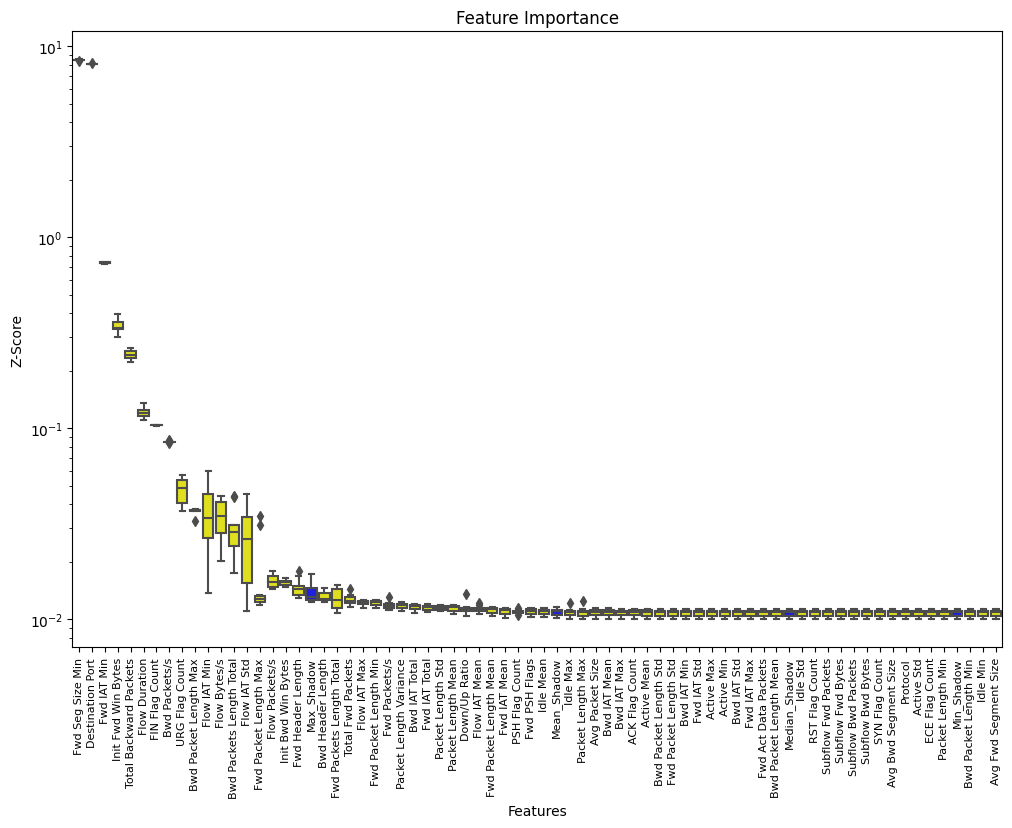

features in the green area: []
features in the blue area: ['Fwd PSH Flags', 'URG Flag Count', 'Flow IAT Max', 'Bwd IAT Min', 'Packet Length Min', 'Active Mean', 'Bwd Packets/s', 'Fwd Act Data Packets', 'Total Fwd Packets', 'Bwd IAT Max', 'Fwd IAT Max', 'Init Bwd Win Bytes', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Idle Std', 'Bwd Packet Length Std', 'Fwd IAT Mean', 'Avg Packet Size', 'Idle Max', 'Flow IAT Std', 'Packet Length Variance', 'Fwd Packets Length Total', 'Flow Packets/s', 'Fwd Seg Size Min', 'Packet Length Max', 'Subflow Bwd Packets', 'Bwd Header Length', 'Active Std', 'Protocol', 'Fwd Packet Length Max', 'Flow IAT Mean', 'Fwd IAT Min', 'Down/Up Ratio', 'Init Fwd Win Bytes', 'Subflow Fwd Bytes', 'Fwd Packet Length Std', 'Packet Length Mean', 'Destination Port', 'Flow Bytes/s', 'Avg Fwd Segment Size', 'Flow Duration', 'Bwd IAT Mean', 'Packet Length Std', 'Idle Min', 'Subflow Fwd Packets', 'PSH Flag Count', 'Bwd Packets Length Total', 'Fwd Pac

,Feature,Method
0,Fwd PSH Flags,Borutashap
1,URG Flag Count,Borutashap
2,Flow IAT Max,Borutashap
3,Bwd IAT Min,Borutashap
4,Packet Length Min,Borutashap
5,Active Mean,Borutashap
6,Bwd Packets/s,Borutashap
7,Fwd Act Data Packets,Borutashap
8,Total Fwd Packets,Borutashap
9,Bwd IAT Max,Borutashap


In [11]:
##Boruta SHAP
from BorutaShap import BorutaShap
#Select features based on BorutaShap method

borutashap_estimator = "LightGBM"
borutashap_trials = 10
borutashap_green_blue = 'both'

################################ Functions ###################################################

def borutashap_feature_selection(data, train_target, borutashap_estimator, borutashap_trials, borutashap_green_blue):

    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # borutashap_estimator - base model (default: XG Boost)
    # borutashap_trials -  number of iteration
    # borutashap_green_blue - choice for green and blue features

    ## Initialize borutashap

    if borutashap_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_borutashap=RandomForestClassifier(n_jobs = -1,
                                                    random_state=1,
                                                    max_depth=7)
    elif borutashap_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_borutashap=lgb.LGBMClassifier(n_jobs = -1,
                                                random_state=101,
                                                max_depth=7)
    else:
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html       
        estimator_borutashap=XGBClassifier(n_jobs = -1,
                                           random_state=101,
                                           max_depth=7)

    ## fit BorutaShap
    # Manual Change in Parameters - BorutaShap
    # Link to function parameters - https://github.com/scikit-learn-contrib/boruta_py
    
    borutashap = BorutaShap(model = estimator_borutashap,
                            importance_measure = 'shap',
                            classification = True)
    
    borutashap.fit(X = data, y = train_target, 
                   n_trials = borutashap_trials)
    
    ## print results
    %matplotlib inline
    borutashap.plot(which_features = 'all')



## print results
    
    green_area = borutashap.accepted
    blue_area = borutashap.tentative
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)
    
    if borutashap_green_blue == "both":
        borutashap_top_features = green_area + blue_area
    
    else:
        borutashap_top_features = green_area
        
    borutashap_top_features_df=pd.DataFrame(borutashap_top_features,
                                            columns = ['Feature'])
    
    borutashap_top_features_df['Method'] = 'Borutashap'
    
    return borutashap_top_features_df,borutashap


################################ Calculate borutashap #################################################

borutashap_top_features_df, borutashap = borutashap_feature_selection(X_train, y_train, 
                                                                      borutashap_estimator, borutashap_trials, borutashap_green_blue)

borutashap_top_features_df.head(n=20)

In [ ]:
### Combination of feature extraction methos

## Result: I decided to use  14 features based on the below result

Selecting features which are picked by more than  3  methods
Final Features Selected:  ['ACK Flag Count', 'Bwd Packet Length Max', 'Bwd Packets Length Total', 'Bwd Packets/s', 'Destination Port', 'Flow Duration', 'Flow IAT Min', 'Flow Packets/s', 'Fwd IAT Min', 'Fwd Packet Length Std', 'Fwd Seg Size Min', 'Init Fwd Win Bytes', 'Packet Length Mean', 'Packet Length Std']


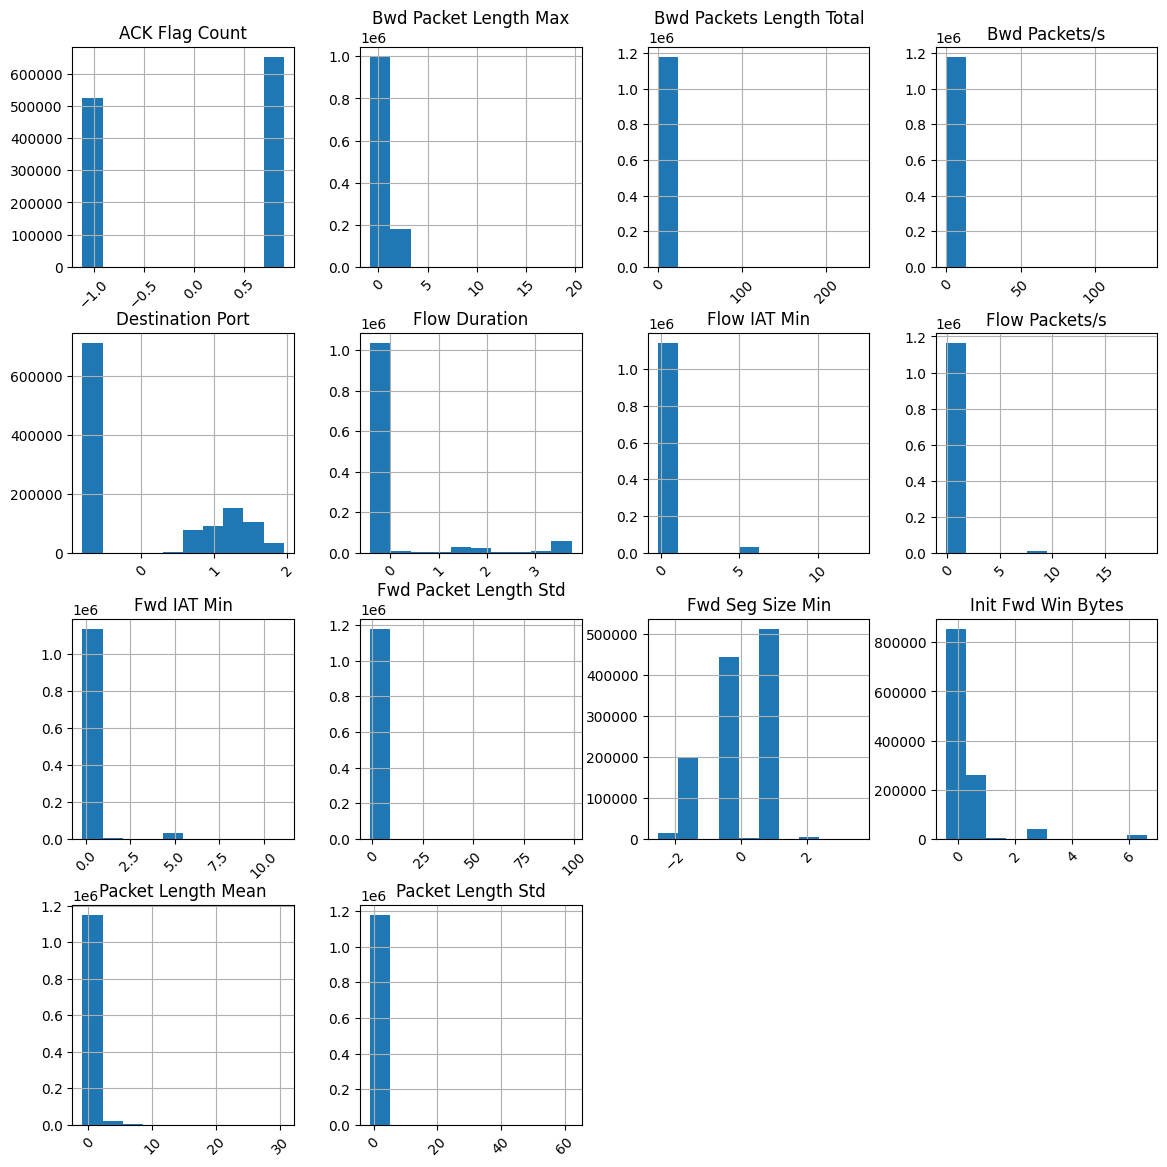

,Features,Count_Method
0,ACK Flag Count,4
14,Bwd Packet Length Max,4
18,Bwd Packets Length Total,4
19,Bwd Packets/s,4
20,Destination Port,4
25,Flow Duration,4
28,Flow IAT Min,4
30,Flow Packets/s,4
35,Fwd IAT Min,4
42,Fwd Packet Length Std,4


In [21]:
# Methods Selected
#sfs_top_features_df, lasso_top_features_df

selected_method = [corr_top_features_df, woe_top_features_df, beta_top_features_df, rfe_top_features_df, 
                   borutapy_top_features_df, borutashap_top_features_df]

# Combining features from all the models

master_df_feature_selection = pd.concat(selected_method, axis =0)
number_of_methods = len(selected_method)
selection_threshold = int(len(selected_method)/2)
print('Selecting features which are picked by more than ', selection_threshold, ' methods')

master_df_feature_selection_v2 = pd.DataFrame(master_df_feature_selection.groupby('Feature').size()).reset_index()
master_df_feature_selection_v2.columns = ['Features', 'Count_Method']
master_df_feature_selection_v3 = master_df_feature_selection_v2[master_df_feature_selection_v2['Count_Method'] > selection_threshold]

final_features = master_df_feature_selection_v3['Features'].tolist()

print('Final Features Selected: ', final_features)
X_train[final_features].hist(figsize = (14,14), xrot =  45)
plt.show()
master_df_feature_selection_v3.head(n=20)

##Save features##

In [40]:
import os
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):
    
    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag
    
    directory = '/content/drive/MyDrive/datasets'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"
    
    # create directory to save the file
    os.makedirs(directory, exist_ok=True)
    
    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [41]:
features = pd.Series(master_df_feature_selection_v3['Features'].values.squeeze(), dtype='str')
save_feature(features=features,
             dataset_name='CIC-IDS2018_extracted_features',
             algorithm='Combination')

The features have been saved in /content/drive/MyDrive/datasets/CIC-IDS2018_extracted_features_Combination_14.csv


In [44]:
columns = features.tolist() +  ['Label']

cic_2018 = df_cic_ids2018[columns]

cic_2018.shape

(1468847, 15)

In [45]:
cic_2018

,ACK Flag Count,Bwd Packet Length Max,Bwd Packets Length Total,Bwd Packets/s,Destination Port,Flow Duration,Flow IAT Min,Flow Packets/s,Fwd IAT Min,Fwd Packet Length Std,Fwd Seg Size Min,Init Fwd Win Bytes,Packet Length Mean,Packet Length Std,Label
0,1.0,693.0,693.0,12.335551,49453.0,162133.0,471.0,30.838879,21707.0,345.66794,20.0,512.0,258.66666,321.782960,0
1,0.0,1460.0,4474.0,13.398827,443.0,746334.0,1.0,24.117887,978.0,172.39940,20.0,8192.0,285.52630,478.689820,0
2,0.0,0.0,0.0,0.000000,0.0,133061.0,48968.0,22.546051,48968.0,0.00000,0.0,-1.0,0.00000,0.000000,0
3,0.0,0.0,0.0,0.000000,137.0,67561383.0,748298.0,0.148014,748298.0,9.29516,8.0,-1.0,58.18182,9.400193,0
4,1.0,0.0,0.0,43478.260000,49453.0,23.0,23.0,86956.520000,0.0,0.00000,20.0,513.0,0.00000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468842,1.0,0.0,0.0,0.000000,80.0,94979.0,39567.0,31.585930,39567.0,0.00000,32.0,225.0,0.00000,0.000000,1
1468843,1.0,0.0,0.0,0.000000,80.0,77941.0,32502.0,38.490653,32502.0,0.00000,32.0,225.0,0.00000,0.000000,1
1468844,1.0,0.0,0.0,0.000000,80.0,86143.0,37778.0,34.825813,37778.0,0.00000,32.0,225.0,0.00000,0.000000,1
1468845,1.0,0.0,0.0,0.000000,80.0,67745.0,23893.0,44.283711,23893.0,0.00000,32.0,225.0,0.00000,0.000000,1


In [46]:
cic_2018.to_csv('/content/drive/MyDrive/datasets/cic_2018_extracted_df', index=False)